# Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn


# Dataloader

In [2]:
#Transforms from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_dataset,validation_dataset = random_split(train_dataset,[round(0.9 * len(train_dataset)), round(0.1 * len(train_dataset))])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
BATCH_SIZE = 128
SHUFFLE = True
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)


## Visualizing Data

# Model

In [4]:
class SCNN(nn.Module):
    def __init__(self, activation: str, batch_norm: str, dropout: bool) -> None:
        super().__init__()

        #BASE MODEL
     
        #VGG Style architecture

        #Conv Block 1
        #(Nx3x32x32) -> (Nx32x16x16)
        conv1_1 = nn.Conv2d(in_channels=3, out_channels=32,
                          kernel_size=3, padding=1)
        conv1_2 = nn.Conv2d(in_channels=32, out_channels=32,
                          kernel_size=3, padding=1)
        pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 2
        #(Nx32x16x16) -> (Nx64x8x8)
        conv2_1 = nn.Conv2d(in_channels=32, out_channels=64,
                            kernel_size=3, padding=1)
        conv2_2 = nn.Conv2d(in_channels=64, out_channels=64,
                            kernel_size=3, padding=1)
        pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 3
        #(Nx64x8x8) -> (Nx128x4x4)
        conv3_1 = nn.Conv2d(in_channels=64, out_channels=128,
                            kernel_size=3, padding=1)
        conv3_2 = nn.Conv2d(in_channels=128, out_channels=128,
                            kernel_size=3, padding=1)
        pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        in_dim = 128*4*4
        fc1 = nn.Linear(in_dim,128)
        fc2 = nn.Linear(128,10)

        activation_layer = None
        dropout_layer = None
        if activation == 'relu':
            activation_layer = nn.ReLU()
        elif activation == 'lrelu':
            activation_layer = nn.LeakyReLU()
        else:
            if activation == 'elu':
                activation_layer = nn.ELU()


        self.conv_net = nn.Sequential(conv1_1,
                                      activation_layer,
                                      conv1_2,
                                      activation_layer,
                                      pool1,
                                      conv2_1,
                                      activation_layer,
                                      conv2_2,
                                      activation_layer,
                                      pool2,
                                      conv3_1,
                                      activation_layer,
                                      conv3_2,
                                      activation_layer,
                                      pool3,
                                      nn.Flatten(start_dim=1),
                                      fc1,
                                      fc2)

        if batch_norm == 'bnorm':
            bnorm1_1 = nn.BatchNorm2d(32)
            bnorm1_2 = nn.BatchNorm2d(32)
            bnorm2_1 = nn.BatchNorm2d(64)
            bnorm2_2 = nn.BatchNorm2d(64)
            bnorm3_1 = nn.BatchNorm2d(128)
            bnorm3_2 = nn.BatchNorm2d(128)

            self.conv_net = nn.Sequential(conv1_1,
                                          bnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          bnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          bnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          bnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          bnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          bnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)
        elif batch_norm == 'gnorm':

            gnorm1_1 = nn.GroupNorm(8, 32)
            gnorm1_2 = nn.GroupNorm(8, 32)
            gnorm2_1 = nn.GroupNorm(8, 64)
            gnorm2_2 = nn.GroupNorm(8, 64)
            gnorm3_1 = nn.GroupNorm(8, 128)
            gnorm3_2 = nn.GroupNorm(8, 128)

            self.conv_net = nn.Sequential(conv1_1,
                                          gnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          gnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          gnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          gnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          gnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          gnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)

        else:
            pass




        #############################################################################################
        #Add dropout in similar way, so one code for all
        ###############################################################################################

    def forward(self, x):
        
        
        y = self.conv_net(x)

        return y

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [5]:
cnn = SCNN(activation='relu',batch_norm='bnorm',dropout=False)
params = count_model_params(cnn)
print(cnn)
print(f"Model has {params} learnable parameters")


SCNN(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Training

## Todo

-> Visualization of images and plots for eval and train loss <br />
-> Early stopping criterion <br />
-> Accuracy above 85% by modifying parameters <br />
-> Visualizing activations of different layers <br />

## Parameters for training

In [6]:
LR = 3e-4
EPOCHS = 50
EVAL_FREQ = 1
SAVE_FREQ = 10
val_loss = 1000

In [7]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = cnn.to(device)

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [10]:
@torch.no_grad()
def eval_model(model):
    correct = 0
    total = 0
    loss_list = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss


def save_model(model, optimizer, epoch, stats, val):
    """ Saving model checkpoint """
    if(not os.path.exists("models")):
        os.makedirs("models")
    if (val):

        savepath = f"models/best_val_{stats['model']}.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)
        
    else:

        savepath = f"models/{stats['model']}_checkpoint_epoch_{epoch}.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)

    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


def test_model(model):

    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    
    return accuracy

In [11]:
loss_hist = []
stats['model'] = 'gnorm'

for epoch in range(EPOCHS):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i,(images,labels) in progress_bar:

        loss_list = []

        x = images.to(device)
        y_train = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = cnn(x)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, y_train)

        # Getting gradients w.r.t. parameters
        loss.backward()
        loss_list.append(loss.item())

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
    
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    

    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)


    #Saving best validation model
    if valid_loss < val_loss:
        val_loss = valid_loss
        save_model(model=cnn, optimizer=optimizer,
                   epoch=epoch, stats=stats, val = True)


    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats,val = False)


save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats, val=False)


Epoch 1 Iter 352: loss 1.01726. : 100%|██████████| 352/352 [00:05<00:00, 70.15it/s]


Accuracy at epoch 0: 58.48%


Epoch 2 Iter 352: loss 0.66654. : 100%|██████████| 352/352 [00:04<00:00, 79.69it/s]


Accuracy at epoch 1: 67.64%


Epoch 3 Iter 352: loss 0.55234. : 100%|██████████| 352/352 [00:04<00:00, 77.36it/s]


Accuracy at epoch 2: 68.8%


Epoch 4 Iter 352: loss 0.55981. : 100%|██████████| 352/352 [00:04<00:00, 77.47it/s]


Accuracy at epoch 3: 72.1%


Epoch 5 Iter 352: loss 0.82754. : 100%|██████████| 352/352 [00:04<00:00, 77.81it/s]


Accuracy at epoch 4: 74.48%


Epoch 6 Iter 352: loss 0.58380. : 100%|██████████| 352/352 [00:04<00:00, 77.15it/s]


Accuracy at epoch 5: 76.32%


Epoch 7 Iter 352: loss 0.24670. : 100%|██████████| 352/352 [00:04<00:00, 77.36it/s]


Accuracy at epoch 6: 74.8%


Epoch 8 Iter 352: loss 0.51441. : 100%|██████████| 352/352 [00:04<00:00, 76.20it/s]


Accuracy at epoch 7: 76.16%


Epoch 9 Iter 352: loss 0.23738. : 100%|██████████| 352/352 [00:04<00:00, 77.41it/s]


Accuracy at epoch 8: 75.08%


Epoch 10 Iter 352: loss 0.20913. : 100%|██████████| 352/352 [00:04<00:00, 76.97it/s]


Accuracy at epoch 9: 76.24%


Epoch 11 Iter 352: loss 0.32505. : 100%|██████████| 352/352 [00:04<00:00, 77.29it/s]


Accuracy at epoch 10: 77.8%


Epoch 12 Iter 352: loss 0.18820. : 100%|██████████| 352/352 [00:04<00:00, 77.93it/s]


Accuracy at epoch 11: 78.26%


Epoch 13 Iter 352: loss 0.11050. : 100%|██████████| 352/352 [00:04<00:00, 77.02it/s]


Accuracy at epoch 12: 77.74%


Epoch 14 Iter 352: loss 0.16739. : 100%|██████████| 352/352 [00:04<00:00, 76.39it/s]


Accuracy at epoch 13: 77.22%


Epoch 15 Iter 352: loss 0.09634. : 100%|██████████| 352/352 [00:04<00:00, 76.47it/s]


Accuracy at epoch 14: 77.42%


Epoch 16 Iter 352: loss 0.06116. : 100%|██████████| 352/352 [00:04<00:00, 74.80it/s]


Accuracy at epoch 15: 76.28%


Epoch 17 Iter 352: loss 0.12967. : 100%|██████████| 352/352 [00:04<00:00, 77.88it/s]


Accuracy at epoch 16: 76.3%


Epoch 18 Iter 352: loss 0.16046. : 100%|██████████| 352/352 [00:04<00:00, 76.81it/s]


Accuracy at epoch 17: 77.12%


Epoch 19 Iter 352: loss 0.15552. : 100%|██████████| 352/352 [00:04<00:00, 77.58it/s]


Accuracy at epoch 18: 76.32%


Epoch 20 Iter 352: loss 0.07894. : 100%|██████████| 352/352 [00:04<00:00, 76.69it/s]


Accuracy at epoch 19: 77.66%


Epoch 21 Iter 352: loss 0.09448. : 100%|██████████| 352/352 [00:04<00:00, 75.94it/s]


Accuracy at epoch 20: 76.52%


Epoch 22 Iter 352: loss 0.10737. : 100%|██████████| 352/352 [00:04<00:00, 78.72it/s]


Accuracy at epoch 21: 75.44%


Epoch 23 Iter 352: loss 0.01436. : 100%|██████████| 352/352 [00:04<00:00, 76.60it/s]


Accuracy at epoch 22: 77.04%


Epoch 24 Iter 352: loss 0.07170. : 100%|██████████| 352/352 [00:04<00:00, 77.79it/s]


Accuracy at epoch 23: 76.8%


Epoch 25 Iter 352: loss 0.02805. : 100%|██████████| 352/352 [00:04<00:00, 76.79it/s]


Accuracy at epoch 24: 76.78%


Epoch 26 Iter 352: loss 0.02699. : 100%|██████████| 352/352 [00:04<00:00, 77.24it/s]


Accuracy at epoch 25: 75.32%


Epoch 27 Iter 352: loss 0.06255. : 100%|██████████| 352/352 [00:04<00:00, 77.58it/s]


Accuracy at epoch 26: 76.28%


Epoch 28 Iter 352: loss 0.10227. : 100%|██████████| 352/352 [00:04<00:00, 76.17it/s]


Accuracy at epoch 27: 78.04%


Epoch 29 Iter 352: loss 0.03436. : 100%|██████████| 352/352 [00:04<00:00, 77.91it/s]


Accuracy at epoch 28: 77.56%


Epoch 30 Iter 352: loss 0.08454. : 100%|██████████| 352/352 [00:04<00:00, 77.16it/s]


Accuracy at epoch 29: 77.72%


Epoch 31 Iter 352: loss 0.06508. : 100%|██████████| 352/352 [00:04<00:00, 77.22it/s]


Accuracy at epoch 30: 76.7%


Epoch 32 Iter 352: loss 0.17641. : 100%|██████████| 352/352 [00:04<00:00, 77.85it/s]


Accuracy at epoch 31: 77.32%


Epoch 33 Iter 352: loss 0.02436. : 100%|██████████| 352/352 [00:04<00:00, 77.68it/s]


Accuracy at epoch 32: 77.86%


Epoch 34 Iter 352: loss 0.00643. : 100%|██████████| 352/352 [00:04<00:00, 78.50it/s]


Accuracy at epoch 33: 78.54%


Epoch 35 Iter 352: loss 0.04097. : 100%|██████████| 352/352 [00:04<00:00, 78.12it/s]


Accuracy at epoch 34: 76.44%


Epoch 36 Iter 352: loss 0.21325. : 100%|██████████| 352/352 [00:04<00:00, 77.71it/s]


Accuracy at epoch 35: 76.44%


Epoch 37 Iter 352: loss 0.04222. : 100%|██████████| 352/352 [00:04<00:00, 76.90it/s]


Accuracy at epoch 36: 76.54%


Epoch 38 Iter 352: loss 0.05915. : 100%|██████████| 352/352 [00:04<00:00, 76.38it/s]


Accuracy at epoch 37: 77.26%


Epoch 39 Iter 352: loss 0.02090. : 100%|██████████| 352/352 [00:04<00:00, 77.63it/s]


Accuracy at epoch 38: 75.22%


Epoch 40 Iter 352: loss 0.02908. : 100%|██████████| 352/352 [00:04<00:00, 77.41it/s]


Accuracy at epoch 39: 77.14%


Epoch 41 Iter 352: loss 0.08648. : 100%|██████████| 352/352 [00:04<00:00, 77.47it/s]


Accuracy at epoch 40: 77.02%


Epoch 42 Iter 352: loss 0.01577. : 100%|██████████| 352/352 [00:04<00:00, 76.76it/s]


Accuracy at epoch 41: 77.96%


Epoch 43 Iter 352: loss 0.02195. : 100%|██████████| 352/352 [00:04<00:00, 76.42it/s]


Accuracy at epoch 42: 78.42%


Epoch 44 Iter 352: loss 0.01237. : 100%|██████████| 352/352 [00:04<00:00, 75.65it/s]


Accuracy at epoch 43: 76.88%


Epoch 45 Iter 352: loss 0.04981. : 100%|██████████| 352/352 [00:04<00:00, 75.31it/s]


Accuracy at epoch 44: 77.1%


Epoch 46 Iter 352: loss 0.01334. : 100%|██████████| 352/352 [00:04<00:00, 77.83it/s]


Accuracy at epoch 45: 76.62%


Epoch 47 Iter 352: loss 0.00613. : 100%|██████████| 352/352 [00:04<00:00, 77.61it/s]


Accuracy at epoch 46: 78.52%


Epoch 48 Iter 352: loss 0.05623. : 100%|██████████| 352/352 [00:04<00:00, 76.87it/s]


Accuracy at epoch 47: 76.3%


Epoch 49 Iter 352: loss 0.08243. : 100%|██████████| 352/352 [00:04<00:00, 76.65it/s]


Accuracy at epoch 48: 77.54%


Epoch 50 Iter 352: loss 0.02012. : 100%|██████████| 352/352 [00:04<00:00, 76.56it/s]


Accuracy at epoch 49: 76.34%


# Testing

# Activation Visualization

In [11]:
savepath = os.path.join(os.getcwd(), "models", "best_val_checkpoint_bnorm.pth")
model,optimizer,epoch,stats= load_model(model=cnn,optimizer=optimizer,savepath=savepath)

In [12]:
# Visualize feature maps
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [13]:
datait = iter(test_loader)

In [14]:
images,labels = datait.next()


In [15]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
activation = {}
model.conv_net[0].register_forward_hook(get_activation('activation_conv1_1'))
model.conv_net[3].register_forward_hook(get_activation('activation_conv1_2'))
model.conv_net[7].register_forward_hook(get_activation('activation_conv2_1'))
model.conv_net[10].register_forward_hook(get_activation('activation_conv2_2'))
model.conv_net[14].register_forward_hook(get_activation('activation_conv3_1'))
model.conv_net[17].register_forward_hook(get_activation('activation_conv3_2'))

output = model(images[0].unsqueeze(0).to(device))
# print(output.shape)




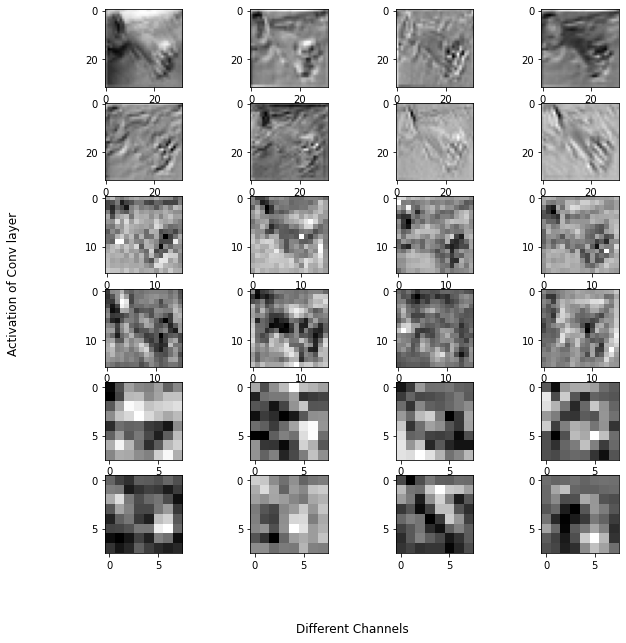

In [43]:
num_plot = 4
fig, axarr = plt.subplots(6, 4, figsize=(10, 10))
fig.supxlabel('Different Channels')
fig.supylabel('Activations of Conv layer')
# fig.tight_layout()

for cnt,(k, v) in zip(range(6),activation.items()):
    act = activation[k].squeeze()    
    for idx in range(num_plot):
        axarr[cnt,idx].imshow(act[idx].cpu().numpy(),cmap="gray")
    
